# Process scRNA-seq data to the input of TFcomb

In this notebook, we process scRNA-seq data from the raw count. We normalized the scRNA-seq data and add important TFs.

## import

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
import celloracle as co
co.__version__
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
import TFcomb as tfc

## Load raw count matrix of scRNA-seq data

In [4]:
data_dir = '../../data/iPSC_example/RNA_data'
adata_anno = sc.read(os.path.join(data_dir,'adata_anno.h5ad')) # scRNA data with annotations
adata_anno

AnnData object with n_obs × n_vars = 8617 × 33538
    obs: 'nCount_RNA', 'nFeature_RNA', 'CellLineSOUPorCELL', 'percent.mt', 'SampleName', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'CellTypeLR', 'celltype'
    var: 'Unnamed: 0'

In [5]:
# - ground-truth TFs in this case
gt_tfs = ['POU5F1',
        'NANOG',
        'SOX2',
        'KLF4',
        'MYC',
        'LIN28A'
                 ]

## Get added TF list

In [6]:
cluster_name = 'celltype'
source_state = 'Fibroblasts'
target_state = 'iPSCs'
base_GRN_dir = os.path.join('../../data/iPSC_example/base_GRN',"base_GRN.parquet")
base_GRN_dir = os.path.join('../../data/iPSC_example/base_GRN',"base_GRN_dataframe_stream.parquet")
add_TF_list = tfc.tl.select_add_TF(adata_anno, cluster_name, source_state, target_state, base_GRN_dir = base_GRN_dir, subset = True)

group_hvg: tf in adata is: 744
group_marker_gene: tf in adata is: 754
group_highexp_gene: tf in adata is: 754
add_TF_list length is: 24


## Filter scRNA data

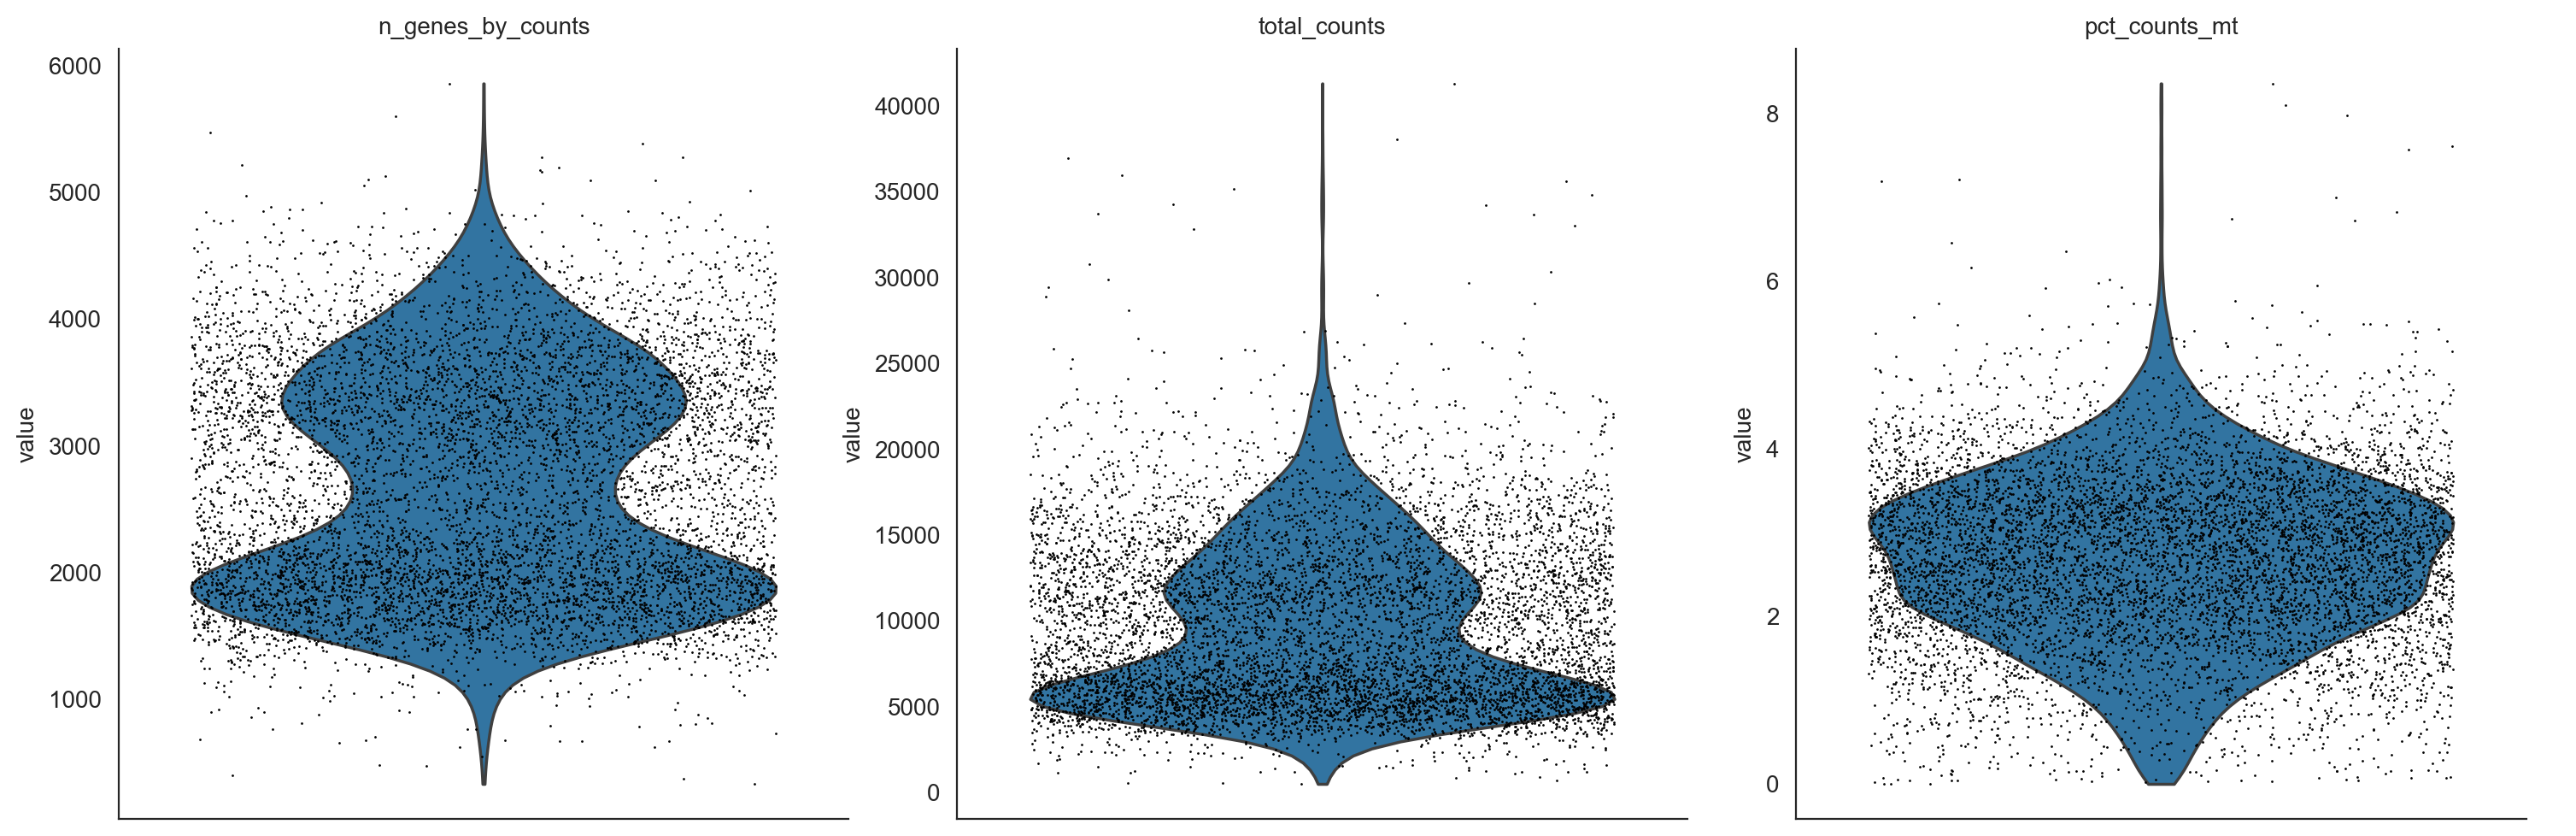

View of AnnData object with n_obs × n_vars = 7841 × 20091
    obs: 'nCount_RNA', 'nFeature_RNA', 'CellLineSOUPorCELL', 'percent.mt', 'SampleName', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'CellTypeLR', 'celltype', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'Unnamed: 0', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [9]:

adata = adata_anno.copy()
adata.var_names_make_unique()


adata = adata[adata.obs[cluster_name].isin([source_state, target_state])].copy()

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

adata = adata[adata.obs.pct_counts_mt < 6, :]

adata

## Plot UMAP

In [10]:
min_mean       =0.0125
max_mean       =3
min_disp       =0.8
n_neighbors    =10
n_pcs          =30

# Normalize gene expression matrix with total UMI count per cell
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')
adata_raw = adata.copy()

sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)


# for tf in filter_tforf_list:
#     adata.var.highly_variable[tf] = True
    
for tf in add_TF_list:
    adata.var.highly_variable[tf] = True
    

adata = adata_raw[:, adata.var.highly_variable]
# Renormalize after filtering
sc.pp.normalize_per_cell(adata)

# keep raw cont data before log transformation
adata.raw = adata
adata.layers["raw_count"] = adata.raw.X.copy()

# Log transformation and scaling
sc.pp.log1p(adata)
sc.pp.scale(adata)


# pca
sc.tl.pca(adata, svd_solver='arpack',random_state=2022)
# neighbors
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs,random_state=2022)
sc.settings.set_figure_params(dpi=180, facecolor='white')
# check umap
sc.tl.umap(adata,random_state=2022)

In [11]:
adata

AnnData object with n_obs × n_vars = 7841 × 1838
    obs: 'nCount_RNA', 'nFeature_RNA', 'CellLineSOUPorCELL', 'percent.mt', 'SampleName', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'CellTypeLR', 'celltype', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts_all', 'n_counts'
    var: 'Unnamed: 0', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

In [12]:
filter_gt_tfs = [i for i in gt_tfs if i in adata.var_names]

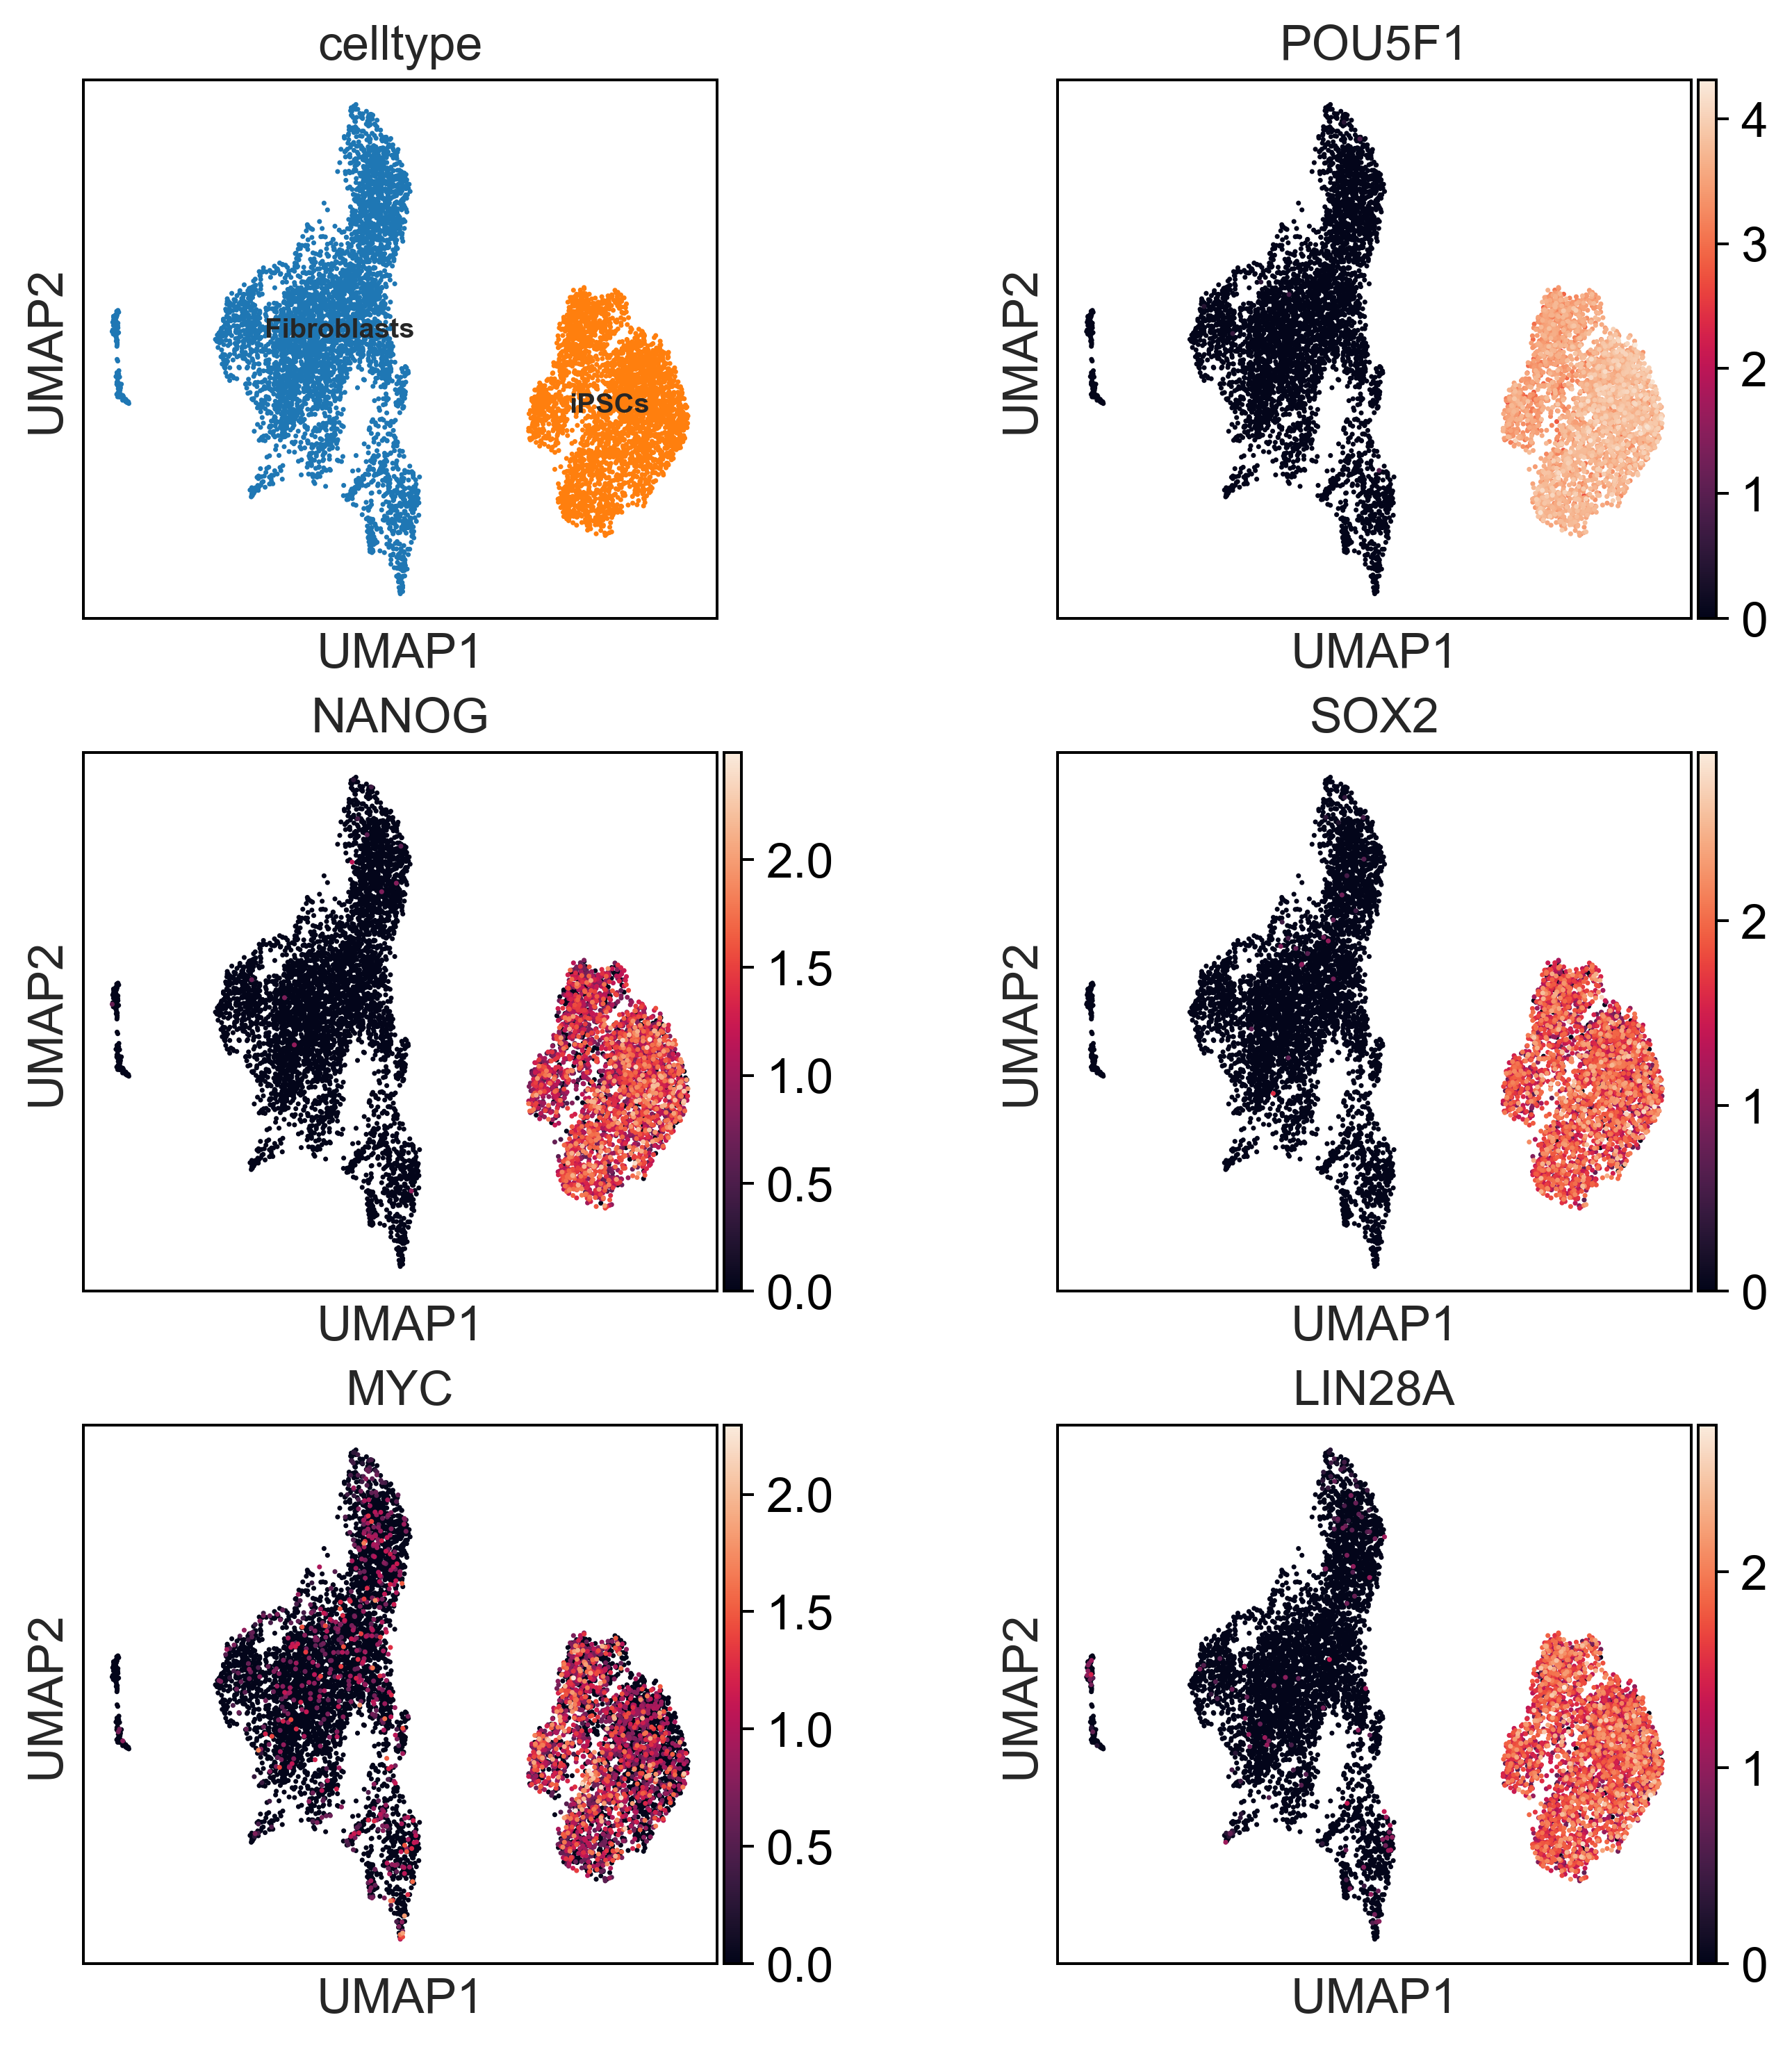

In [13]:
point_size = 8
sc.settings.set_figure_params(dpi=180, facecolor='white')
plt.rcParams["figure.figsize"] = [3, 3]
sc.pl.umap(adata, color=['celltype'] + filter_gt_tfs,size=point_size,legend_fontsize=8,
           ncols=2, wspace=0.4,legend_loc='on data')

In [14]:
adata.write('../../data/iPSC_example/RNA_data/adata_rna.h5ad')